In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# ensure that any edits to libraries you make are reloaded here automatically,
# and also that any charts or images displayed are shown in this notebook.


import numpy as np
import scipy as sc
import sklearn as sk
from sklearn import datasets, linear_model, model_selection, metrics
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [12, 8]

import time
import datetime


#from sklearn.preprocessing import MinMaxScaler

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torch

import compare_models_functions as myfxns


def sliding_windows(data, seq_length):
    '''given 1D arr of timepoints, return array of sliding windows (x) 
    and value immediately following (y)'''
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)






In [ ]:

# dict of fips to county, state (capitalized)
fips2countystateD = myfxns.make_fips2countystateD()

In [2]:

# LSTM, predicting 1 day at a time, trained on sliding window



class SeqDataset(torch.utils.data.Dataset):
    '''dataset that optionally maintains list of IDs for each sample (e.g. county name or fips).
    inputs, labels, and list_IDs must be in same order'''
    def __init__(self, inputs, labels, has_header_col=False):
        'Initialization'

        self.inputs = inputs # assume 2D array, each row is sample
        self.labels = labels # assume 2D, each row is sample
        self.list_IDs = ['no_id' for i in range(self.inputs.shape[0])]
            
        if has_header_col: # if inputs has header col
            self.list_IDs = inputs[:,0]
            self.inputs = inputs[:,1:]

    def __len__(self):
        'Denotes the total number of samples'
        return self.inputs.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        
        sample_id = self.list_IDs[index]
    
        X = torch.Tensor(self.inputs[index,:])
        y = torch.Tensor(self.labels[index,:])

        return X, y, sample_id
    
    # could add option to look up ID of a datapoint, and make inputs and labels dictionary
    #ID = self.list_IDs[index]
    

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size=1, output_dim=1,
                    num_layers=10, dropout=0.2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim   # how many features per time point (or token)
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_dim = output_dim

        # lstm layers and linear layer to output single time point
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, 
                            dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        
        # hidden layer
        self.hidden = (torch.zeros(self.batch_size, self.num_layers, self.hidden_dim),
                torch.zeros(self.batch_size, self.num_layers, self.hidden_dim))
 
    def reset_hidden(self): # use to reset hidden state
        self.hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        # should it be this for batch first?? TODO
        #self.hidden = (torch.zeros(self.batch_size, self.num_layers, self.hidden_dim),
        #        torch.zeros(self.batch_size, self.num_layers, self.hidden_dim))
    

    def forward(self, inputs):
        # note: dim depends on whether lstm layer initialized with batch_first. 
        # Code assumes batch_first, unidirectional
        
        # nn.LSTM expects input shape ( timepoints, batch_size, features per timepoint)
        #        or (batch_size, timepoints, features per timepoint) if batch_first
        # lstm_out: (seq_len, batch, num_directions * hidden_size) 
        #        or (batch, seq_len, numdir*hidden_size)
        # self.hidden: tup of two (num_layers, batch_size, hidden_dim)
        #                     or (batch_size, num_layers, hidden_dim)
        lstm_out, self.hidden = self.lstm(inputs.view(self.batch_size, -1, self.input_dim), self.hidden) 
        # linear layer takes output of final timestep
        y_pred = self.linear(lstm_out[:,-1,:])
        
        return y_pred
    

# input_dim = # of features per timepoint/token
# pred_seq_len = # days to output at once
def train_lstm(train_dataset, batch_size=100, num_epochs=10, lr=0.05, loss_fxn='MSE',
               input_dim=1, hidden_dim=21, pred_seq_len=1, num_layers=2, lstm_dropout=0.5):
    '''simple train function w batches w/o early stopping or checkpoints'''
    
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, 
                              num_workers = 4, drop_last = True)
    # TODO handle batches which aren't multiple of whole dataset, currently drop, could pad


    model = LSTM(input_dim, hidden_dim, output_dim=pred_seq_len, batch_size=batch_size, 
                 num_layers=num_layers, dropout=lstm_dropout)
    print('training model with [hidden dim %d, num layers %d, dropout %.3f, loss %s, batch %d, lr %.5f, epoch %d]' 
          % (hidden_dim, num_layers, lstm_dropout, loss_fxn, batch_size, lr, num_epochs) )
    model = model.to(DEVICE)
    model = model.train()
    ####model = model.double() # set model to use double, otherwise float vs double error
    
    criterion = torch.nn.MSELoss() # regression
    if loss_fxn == 'L1':
        criterion = torch.nn.L1Loss()
        
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) # can try other optimizer

    #num_batches = int(len(train_dataset) / float(batch_size)) + 1
    

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get batch
            inputs, labels, sample_id = data[0].to(DEVICE), data[1].to(DEVICE), data[2]
                        
            # zero the parameter gradients and reset hidden
            optimizer.zero_grad()
            model.reset_hidden()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # update loss
            running_loss += loss.item()


        #End of epoch report (could do per item loss)
        if epoch % 1 == 0:
            print('[Epoch %d] loss: %.3f' %
                  (epoch + 1, running_loss )) 

    print('Finished Training')
    return model




In [9]:
## now train on sliding windows (multiple windows per county)
# hold out last 7 days for test

# TODO could take log and exponentiate in forward or in data loader

cases_df, deaths_df = myfxns.load_county_datasets()

use_last_n_days=28
use_log_counts = True
# filter data - only use 28 days as features, and use only counties with 28 days
X_df, X, y = myfxns.filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
    use_last_n_days=use_last_n_days,  max_frac_missing=0.0, 
    use_rel_counts=False, use_log_counts=use_log_counts, use_counts_only = True)
print('use_last_n_days: %d, use_log_counts: %d' % (use_last_n_days, use_log_counts))

X = np.array(  X_df.drop(['county', 'state'], axis=1) ) 
Xtrain = X[:,:-7] # first col of X is fips, which is converted to sampleID in data loader


input_seq_len = 14   # use past 2 weeks to predict next day

# generate sliding windows to train on
# total number of samples will be num counties * num windows for each
num_counties = Xtrain.shape[0]
num_dates = Xtrain.shape[1] - 1 # don't include fips
if input_seq_len > num_dates:
    print('WARNING: input seq len %d is longer than number of dates %d available for training'
          % (input_seq_len, num_dates) )
num_windows = num_dates - input_seq_len - 1 # num windows per county
print('num counties, dates, windows:', num_counties, num_dates, num_windows)

# slide_train contains [fips, ct1, ..., ct14, ct15] for input seq len
# fips is col 0, middle is input seq, target is last col
slide_train = -1*np.ones((num_counties*num_windows, input_seq_len + 2))

for i in range(Xtrain.shape[0]):
    x, y = sliding_windows(Xtrain[i,1:], input_seq_len)
    fips_i = X[i,0]
    rows_i = tuple(range((i*num_windows),((i+1)*num_windows)))
    slide_train[rows_i,0] = fips_i
    slide_train[rows_i,1:-1] = x
    slide_train[rows_i,-1] = y
print('made sliding windows for training')

# now train on sliding windows, predict only 1 day into future
DEVICE = torch.device('cpu') # use 'cpu' for debug, 'cuda' for run on gpu
print('Using device: ' + str(DEVICE))

# if you want validation set or hold out sequences for testing
#slide_train, slide_valid = model_selection.train_test_split(data_sliding, test_size=0.2)


# note: labels should be a 2D array, even if only predicting 1 day at a time
train_dataset = SeqDataset(slide_train[:,:-1], slide_train[:,-1].reshape((-1,1)), has_header_col=True)
hidden_dim=10
num_layers=1
batch_size=50
lr=0.02
num_epochs=20
slide_model = train_lstm(train_dataset, num_epochs=num_epochs, batch_size=batch_size, lr=lr, pred_seq_len = 1,
                        hidden_dim=hidden_dim, num_layers=num_layers, loss_fxn = 'MSE', lstm_dropout=0.5)


# [hidden dim 20, num layers 2, dropout 0.500, loss MSE, batch 100, lr 0.01000, epoch 20]
# [hidden dim 10, num layers 1, dropout 0.000, loss MSE, batch 50, lr 0.02000, epoch 20]
# note: lstm dropout after all but last layer, so no dropout if 1 layer


use_last_n_days: 28, use_log_counts: 1
num counties, dates, windows: 2320 21 6
made sliding windows for training
Using device: cpu
training model with [hidden dim 10, num layers 1, dropout 0.500, loss MSE, batch 50, lr 0.02000, epoch 20]
[Epoch 1] loss: 199.931
[Epoch 2] loss: 16.748
[Epoch 3] loss: 10.091
[Epoch 4] loss: 6.071
[Epoch 5] loss: 5.359
[Epoch 6] loss: 5.194
[Epoch 7] loss: 4.151
[Epoch 8] loss: 4.014
[Epoch 9] loss: 4.673
[Epoch 10] loss: 3.669
[Epoch 11] loss: 3.609
[Epoch 12] loss: 3.391
[Epoch 13] loss: 3.391
[Epoch 14] loss: 3.248
[Epoch 15] loss: 3.202
[Epoch 16] loss: 3.156
[Epoch 17] loss: 3.033
[Epoch 18] loss: 3.085
[Epoch 19] loss: 2.959
[Epoch 20] loss: 2.941
Finished Training


In [11]:
# predict held-out 7 days, using model trained on sliding windows
## here, predict using prev day + current hidden state

# i did not scale training data, but use inverse_transform if scaled


slide_model.reset_hidden()
slide_model.eval().cpu()
slide_model.batch_size = 1 # if want to run on one sample at a time


preds = np.copy(X) # first col fips
preds[:,-7:] = -1  # last 7 cols of preds will be predictions

preds_dataset = SeqDataset(preds, preds, has_header_col=True)
preds_county_loader = DataLoader(preds_dataset, batch_size = 1, shuffle = False, 
                              num_workers = 4, drop_last = True)

# TODO this could be easily done in batches
print('predicting on held out 7 days...')
with torch.no_grad():
    for i, data in enumerate(preds_county_loader, 0):
        data_i, dummy_labels, fips = data[0], data[1], data[2]
        # pass in entire train sequence for county i to predict first of future days
        input_seq = data_i[:,-(8 + input_seq_len):-8] # data_i is batch_size x num days total
        #print(input_seq)
        #print('hidden before', slide_model.hidden)
        slide_model.reset_hidden()
        #print('hidden after', slide_model.hidden)
        next_day_pred = slide_model(input_seq) #.item()
        data_i[0,-7] = next_day_pred  # update data_i before it's passed in for next day
        preds[i,-7] = next_day_pred
        #print('input', i, input_seq)
        for j in range(6,0,-1): # fill in rest of days
            input_seq = data_i[:,-(j+1):-j] # pass in prev day
            next_day_pred = slide_model(input_seq) #.item() # pred next day
            data_i[0,-j] = next_day_pred 
            preds[i,-j] = next_day_pred



print(X[0:500:150, -7:])
print(preds[0:500:150, -7:])



predicting on held out 7 days...
[[3.58 3.61 3.61 3.66 3.69 3.76 3.74]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [5.   5.01 5.02 5.02 5.08 5.11 5.16]
 [5.11 5.11 5.11 5.12 5.14 5.18 5.21]]
[[3.5  3.54 3.57 3.61 3.65 3.68 3.72]
 [0.06 0.08 0.1  0.12 0.13 0.15 0.16]
 [4.91 4.94 4.98 5.01 5.05 5.08 5.12]
 [5.11 5.14 5.17 5.21 5.24 5.28 5.31]]


5053.0 Grant Arkansas #1f77b4
6075.0 San Francisco California #ff7f0e
8043.0 Fremont Colorado #2ca02c
9001.0 Fairfield Connecticut #d62728
11001.0 District of Columbia District of Columbia #9467bd
12115.0 Sarasota Florida #8c564b
16027.0 Canyon Idaho #e377c2
22071.0 Orleans Louisiana #7f7f7f
26065.0 Ingham Michigan #bcbd22
28111.0 Perry Mississippi #17becf
28127.0 Simpson Mississippi #1f77b4
29047.0 Clay Missouri #ff7f0e
29189.0 St. Louis Missouri #2ca02c
34001.0 Atlantic New Jersey #d62728
35006.0 Cibola New Mexico #9467bd
36087.0 Rockland New York #8c564b
36105.0 Sullivan New York #e377c2
37045.0 Cleveland North Carolina #7f7f7f
45087.0 Union South Carolina #bcbd22
48085.0 Collin Texas #17becf
48113.0 Dallas Texas #1f77b4
55009.0 Brown Wisconsin #ff7f0e


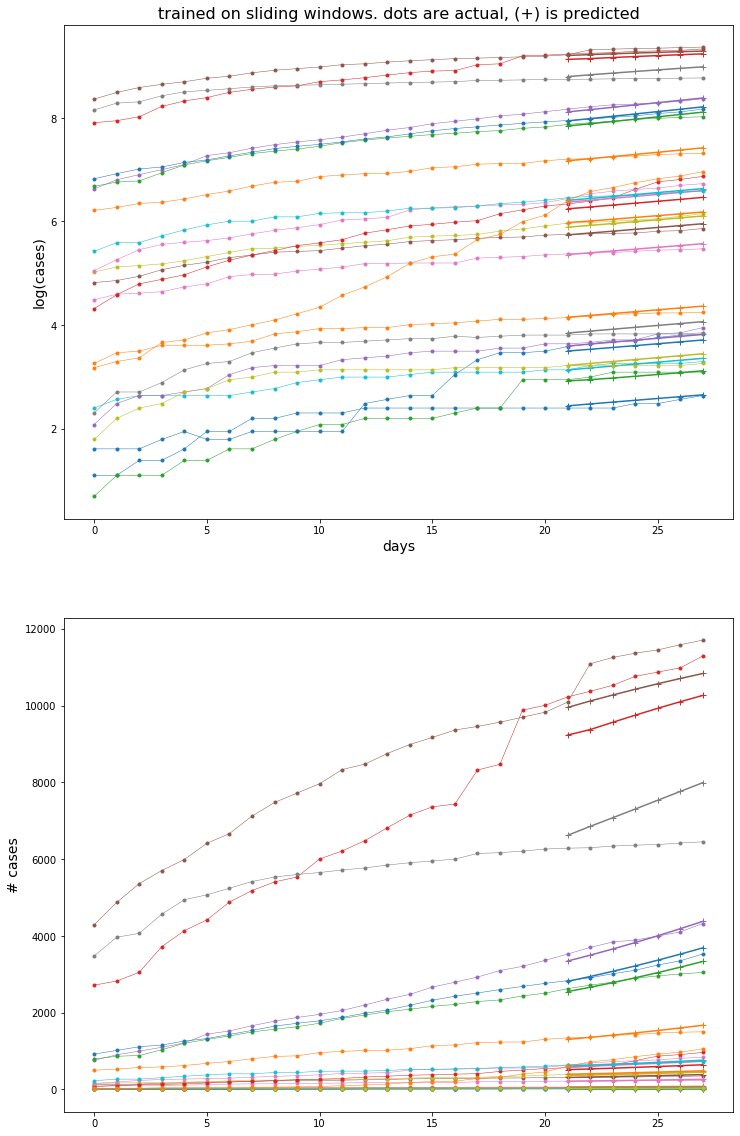

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#ff7f0e']


In [12]:
## plot some predictions from sliding window model feeding in 1 day
np.random.seed(9) #13) #9
fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(12,20))
axs[0].set_xlabel('days', size=14)
axs[0].set_ylabel('log(cases)', size=14)
axs[1].set_ylabel('# cases', size=14)

axs[0].set_title('trained on sliding windows. dots are actual, (+) is predicted', size=16)


# now, X contains fips and true data
# preds contains fips, and last 7 cols are predictions

# select random subset of counties to plot
#idxs = np.random.choice(range(preds.shape[0]), size=(20,))
colorsL = [] # track colors

# combined fips from a couple random sets plus a couple large counties

fipsL = [16027.,  9001.,  5053., 28111., 35006.,  8043., 28127., 36105., 48085., 26065.,
 37045., 55009., 12115., 34001., 29047., 45087., 36087., 48113.0, 06075.0, 11001.0, 22071.0, 29189.0 ]

idxs = np.where(np.isin(X[:,0], fipsL))[0]
num_pred_days = 7
num_train_days = use_last_n_days - num_pred_days
for i in idxs:
    # plot actual log(cases)
    fips_i = X[i,0]
    df_i = X_df.loc[X_df['fips']==fips_i].iloc[0]
    p = axs[0].plot(range(use_last_n_days), X[i,1:], marker='.', linewidth=0.5)
    color = p[0].get_color()
    
    # plot pred log(cases)
    axs[0].plot(range(num_train_days,use_last_n_days), preds[i,-num_pred_days:], marker='+', c=color)
    
    # plot actual cases
    axs[1].plot(range(use_last_n_days), np.exp(X[i,1:]), marker='.', linewidth=0.5)

    # plot pred cases
    axs[1].plot(range(num_train_days,use_last_n_days), np.exp(preds[i,-num_pred_days:]), marker='+', c=color)

    # if not use_log_cases:
    
    colorsL.append(color)
    print(fips_i, df_i['county'], df_i['state'], color)

    
plt.show()
#print('fips shown:', X[idxs,0])
#print('fips and corresponding colors:', list( zip(X[idxs,0], colorsL)) )
print(colorsL)
    

In [23]:




print(X_df.columns.shape)
print(X_df.columns[3])
print(X_df.columns[-7])
print(X_df.columns[-1])

startDate = datetime.date(2020, 4, 24)
endDate = datetime.date(2020, 4, 30)
hidden_dim=10
num_layers=1
batch_size=50
lr=0.02
num_epochs=20
fname = 'prediction_csv/test_lstm_%d_%d_%d_%.3f_%d.csv' % (hidden_dim, num_layers, batch_size, lr, num_epochs) 
myfxns.output_csv_preds(preds, fips2countystateD, startDate, endDate, fname, 
                 convertLog=True, startCol=-7, endCol=None)

with open(fname) as f:
    i = 0
    for line in f:
        print(line)
        i += 1
        if i>3: break

(31,)
2020-04-03 00:00:00
2020-04-24 00:00:00
2020-04-30 00:00:00
converted predictions from log(cases) to # cases for output
[datetime.date(2020, 4, 24), datetime.date(2020, 4, 25), datetime.date(2020, 4, 26), datetime.date(2020, 4, 27), datetime.date(2020, 4, 28), datetime.date(2020, 4, 29), datetime.date(2020, 4, 30)]
['4/24/20', '4/25/20', '4/26/20', '4/27/20', '4/28/20', '4/29/20', '4/30/20']
,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20

"Autauga, Alabama, US",33.09253182972206,34.316373326824326,35.600971021135436,36.93689692086675,38.32498186619494,39.76608418538291,41.261178323691176

"Baldwin, Alabama, US",135.83751732803017,140.48320014439398,145.3748066623512,150.44972265767262,155.71293689232013,161.1710342237388,166.8303940166912

"Barbour, Alabama, US",29.86698081377465,30.90923692886151,32.02150716276653,33.19396138308913,34.42376987984486,35.70888005187995,37.04795426750186



In [ ]:
# other options for training/predicting LSTM - reset hidden between preds, holdout counties instead of days

# predict held-out 7 days, using model trained on sliding windows
# predict each new day using past 14 days

# did not scale training data, but use inverse_transform if scaled
slide_model.reset_hidden()
slide_model.eval().cpu().double()
slide_model.batch_size = 1 # if want to run on one sample at a time


preds = np.copy(X) # first col fips
preds[:,-7:] = -1  # last 7 cols of preds will be predictions

preds_dataset = SeqDataset(preds, preds, has_header_col=True)
county_loader = DataLoader(preds_dataset, batch_size = 1, shuffle = False, 
                              num_workers = 4, drop_last = True)

# TODO this could be easily done in a large batch at a time. dataset small so doesn't matter much, takes a min
print('predicting on held out 7 days')
with torch.no_grad():
    for i, data in enumerate(county_loader, 0):
        data_i, dummy_labels, fips = data[0], data[1], data[2]
        
        for j in range(7,0,-1):
            input_seq = data_i[:,-(j+15):-(j+1)].double() # pass in prev 14 days
            slide_model.reset_hidden()
            next_day_pred = slide_model(input_seq).item() # pred next day
            data_i[0,-j] = next_day_pred
            preds[i,-j] = next_day_pred

            

print(X[0:1000:100, -7:])
print(preds[0:1000:100, -7:])

## plot some predictions from sliding window model

fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(12,20))
axs[0].set_xlabel('days', size=14)
axs[0].set_ylabel('log(cases)', size=14)
axs[1].set_ylabel('# cases', size=14)

axs[0].set_title('trained on sliding windows. dots are actual, (+) is predicted', size=16)


# now, X contains fips and true data
# preds contains fips, and last 7 cols are predictions

# select random subset of counties to plot
idxs = np.random.choice(range(preds.shape[0]), size=(20,))
colorsL = [] # track colors
for i in idxs:
    # plot actual log(cases)
    p = axs[0].plot(range(28), X[i,1:], marker='.', linewidth=0.5)
    color = p[0].get_color()
    
    # plot pred log(cases)
    axs[0].plot(range(21,28), preds[i,-7:], marker='+', c=color)
    
    # plot actual cases
    axs[1].plot(range(28), np.exp(X[i,1:]), marker='.', linewidth=0.5)

    # plot pred cases
    axs[1].plot(range(21,28), np.exp(preds[i,-7:]), marker='+', c=color)

    colorsL.append(color)

plt.show()
print('fips shown:', X[idxs,0])
print('fips and corresponding colors:', list( zip(X[idxs,0], colorsL)) )
    
    


In [ ]:
## train LSTM: here using one sample per county, outputting next week all at once

# preprocess data
# only use 28 days, and use all counties with 28 days
X_df, X, y = myfxns.filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
    use_last_n_days=28,  max_frac_missing=0.0, 
    use_rel_counts=False, use_log_counts = True, use_counts_only = True)

#X = np.array(X_df.iloc[:,3:]) # each row county, each col is counts for 28 days
X = np.array(  X_df.drop(['county', 'state'], axis=1) ) 
# Note: in X, keep fips as first column, convert to sample id in dataloader

# split data (currently split into train/test counties, but could split into train/test days or both)
Xtrain, Xtest = model_selection.train_test_split(X, test_size=0.25)

pred_seq_len = 7
Xtrain_inputs = Xtrain[:,:-pred_seq_len]
Xtrain_labels = Xtrain[:,-pred_seq_len:] # predict last 7 days
Xtest_inputs = Xtest[:,:-pred_seq_len]
Xtest_labels = Xtest[:,-pred_seq_len:]

'''
# normalize inputs (best practice for lstm)
# didn't seem to make much difference, so omitted for now
# can expt here, larger values may be seen in latest samples so not sure if appropriate
scaler = MinMaxScaler()
scaler = scaler.fit(Xtrain_inputs)
Xtrain_inputs = scaler.transform(Xtrain_inputs)
Xtest_inputs = scaler.transform(Xtest_inputs)
'''

DEVICE = torch.device('cpu') # 'cpu')
print('Using device: ' + str(DEVICE))

train_dataset = SeqDataset(Xtrain_inputs, Xtrain_labels, has_header_col=True)
batch_size=30
model = train_lstm(train_dataset, num_epochs=30, batch_size=batch_size,lr=0.02, pred_seq_len = pred_seq_len)

In [ ]:
# predict on holdout counties, plot a few examples

model.reset_hidden()
model.double().to(DEVICE).eval()
#train_dataset = SeqDataset(Xtrain_inputs, Xtrain_labels, has_header_col=True)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, 
                              num_workers = 4, drop_last = True)


test_dataset = SeqDataset(Xtest_inputs, Xtest_labels, has_header_col=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, 
                              num_workers = 4, drop_last = True)


fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12,10))
ax.set_xlabel('days', size=14)
ax.set_ylabel('log(cases)', size=14)
ax.set_title('some heldout counties. dots are actual, (+) is predicted', size=16)

with torch.no_grad():
    for i, data in enumerate(test_loader, 0): # train_loader, 0):
        # only plot first sample from each batch, could also set batch_size 1 and pick subset
        # note: sample_id is fips, can use to make legend or print sample id, color if you like
        inputs, labels, sample_id = data[0].to(DEVICE), data[1].to(DEVICE), data[2]
        model.reset_hidden()
        preds = model(inputs.double()).detach().cpu().numpy()
        # remember to untransform inputs
        # TODO with torch.nograd prob easier
        inputs = inputs.detach().cpu().numpy() 
        #inputs = scaler.inverse_transform(inputs)
        labels = labels.detach().cpu().numpy()

        end_train = 28 - pred_seq_len
        p = ax.plot(range(end_train), inputs[0], marker='.', 
                    linewidth=0.5) # actual log(cases)
        color = p[0].get_color()
        end = 21+pred_seq_len
        ax.plot(range(end_train,28), labels[0], c=color, marker='.', linewidth=0.5) # actual log(cases), last week
        ax.plot(range(end_train, 28), preds[0], c=color, marker='+', linewidth=1.5) # pred log(cases), last week

        if i>15:
            break
    
plt.show()




#preds_train = []
#labels_train = []

fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12,10))
ax.set_xlabel('days', size=14)
ax.set_ylabel('log(cases)', size=14)
ax.set_title('some train counties. dots are actual, (+) is predicted', size=16)

with torch.no_grad():
    for i, data in enumerate(train_loader, 0): # train_loader, 0):
        # only plot first sample from each batch
        inputs, labels, sample_id = data[0].to(DEVICE), data[1].to(DEVICE), data[2]
        model.reset_hidden()
        preds = model(inputs.double()).detach().cpu().numpy()
        # remember to untransform inputs
        inputs = inputs.detach().cpu().numpy()
        #inputs = scaler.inverse_transform(inputs)
        labels = labels.detach().cpu().numpy()

        end_train = 28 - pred_seq_len
        p = ax.plot(range(end_train), inputs[0],marker='.', linewidth=0.5) # actual log(cases)
        color = p[0].get_color()
        end = 21+pred_seq_len
        ax.plot(range(end_train,28), labels[0], c=color, marker='.', linewidth=0.5) # actual log(cases), last week
        ax.plot(range(end_train, 28), preds[0], c=color, marker='+', linewidth=1.5) # pred log(cases), last week

        if i>15:
            break

    plt.show()


In [ ]:
## note: counties can have decreasing cases from day to day, ex/ fips 05011
X_df, X, y = myfxns.filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
    use_last_n_days=28,  max_frac_missing=0.0, 
    use_rel_counts=False, use_log_counts = True, use_counts_only = True)

print('Example of decreasing case or log(case)) counts:')
# Bradley county, april 4 to april 5
print(X_df[X_df['fips'] == 5011].iloc[:,0:3])
print(X_df[X_df['fips'] == 5011].iloc[:,-25:-16])


In [ ]:
# TODO predict cases and deaths simultaneously
# TODO try passing in differences instead of raw counts
# TODO add one-hot encoding of state to linear layer, can modify data loader to handle this using fip2labelID
# TODO add one-hot encoding of state to linear layer, can modify data loader to handle this using fip2labelID

# TODO pass in exogenous data for each county
# maybe predict multiple counties simultaneously (no new counties, wouldn't work for holdout set of counties tho)

In [ ]:
# TODO arima using other counties, deaths, state-level testing as exogenous 

# TODO add proportion or number tested as feature
# state-level data available here, including time series starting from feb 28:
# https://covidtracking.com/data

# TODO will output predictions from ARIMA and LSTM models in the prediction_csv/ directory
